<a href="https://colab.research.google.com/github/RodrigoTito/Credit-Risk---App-Dash-/blob/main/Risco_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Risco de crédito por CapitainData

O conjunto de dados classifica as pessoas descritas por um conjunto de atributos como riscos de crédito **bons** ou **ruins**. Inclui dados que variam de histórico de crédito, finalidade, contagem de dependentes e outros que dão uma ideia justa da pessoa que está buscando o crédito. 


 *O objetivo é construir um modelo de **aprendizado de máquina** para prever se um crédito  dado a um indivíduo é um risco **bom** ou **ruim**.*

* Bibliotecas

In [ ]:
!pip install catboost
!pip install tensorflow-addons
!pip install datetransform

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")

#Evaluation Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
import tensorflow_addons as tfa
from datetransform.transform import add_date_features
from tqdm import tqdm

* Carregar Dados

In [3]:
sorted(os.listdir("/content"))

['.config', 'sample_data']

In [5]:
test, train = [pd.read_csv(f"../content/{f}", ) for f in sorted(os.listdir("../content"))[-2:]]

In [54]:
df = train.drop('Unnamed: 0', axis=1)

### EDA - Análise Exploratória de Dados

* Os tamanhos dos datasets

In [38]:
[x.shape for x in [test, train]]

[(200, 20), (800, 22)]

* Variáveis dos datasets

In [39]:
[x.columns for x in [test, train]]

[Index(['checking_status', 'duration', 'credit_history', 'purpose',
        'credit_amount', 'savings_status', 'employment',
        'installment_commitment', 'personal_status', 'other_parties',
        'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
        'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
        'foreign_worker'],
       dtype='object'),
 Index(['Unnamed: 0', 'checking_status', 'duration', 'credit_history',
        'purpose', 'credit_amount', 'savings_status', 'employment',
        'installment_commitment', 'personal_status', 'other_parties',
        'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
        'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
        'foreign_worker', 'class'],
       dtype='object')]

* Colunas diferentes 

In [40]:
train.columns.difference(test.columns)

Index(['Unnamed: 0', 'class'], dtype='object')

* Tipo das variáveis

In [41]:
train.dtypes.value_counts()  

object    13
int64      9
dtype: int64

* Visualizando o dataset train

In [42]:
train.head()

,Unnamed: 0,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0,'no checking',18,'critical/other existing credit',radio/tv,1800,'<100','1<=X<4',4,'male single',none,2,car,24,none,own,2,skilled,1,none,yes,1
1,1,'<0',24,'existing paid',radio/tv,2439,'<100','<1',4,'female div/dep/mar',none,4,'real estate',35,none,own,1,skilled,1,yes,yes,0
2,2,'no checking',36,'no credits/all paid',repairs,2613,'<100','1<=X<4',4,'male single',none,2,car,27,none,own,2,skilled,1,none,yes,1
3,3,'no checking',15,'existing paid',education,4623,'100<=X<500','1<=X<4',3,'male single',none,2,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,0
4,4,'<0',21,'existing paid',furniture/equipment,3599,'<100','4<=X<7',1,'female div/dep/mar',none,4,car,26,none,rent,1,'unskilled resident',1,none,yes,1


* Resumo de cada variável do dataset

In [43]:
df_aux = pd.DataFrame({'Type': train.dtypes,
                      'Missing': train.isna().sum(),
                      'Size': train.shape[0],
                       'Unique': train.nunique()
                     })
df_aux['Missing_%']= df_aux.Missing/df_aux.Size * 100
df_aux.sort_values(by='Missing_%', ascending=False)

,Type,Missing,Size,Unique,Missing_%
Unnamed: 0,int64,0,800,800,0.0
checking_status,object,0,800,4,0.0
foreign_worker,object,0,800,2,0.0
own_telephone,object,0,800,2,0.0
num_dependents,int64,0,800,2,0.0
job,object,0,800,4,0.0
existing_credits,int64,0,800,4,0.0
housing,object,0,800,3,0.0
other_payment_plans,object,0,800,3,0.0
age,int64,0,800,53,0.0


Column name   | Descrição 
--------- | ------------
checking_status|	Status da conta corrente existente, em marco alemão
duration|	Duração em meses
credit_history|	Histórico de crédito (créditos recebidos, pagos devidamente, atrasos, contas críticas)
purpose|	Finalidade do crédito (carro, televisão, ...)
credit_amount|	Quantidade de crédito
savings_status|	Status da conta de poupança / títulos, em marcos alemães
employment|	Emprego atual, em número de anos
installment_commitment|	Taxa de parcelamento em porcentagem da renda disponível
personal_status|	Status pessoal (casado, solteiro, ...) e sexo
other_parties|	Outros devedores / fiadores
residence_since|	Residência atual desde X anos
property_magnitude|	Propriedade (por exemplo, imóveis)
age|	Idade em anos
other_payment_plans|	Outros planos de parcelamento (bancos, lojas)
housing| Habitação (aluguel, próprio, ...)
existing_credits|	Número de créditos existentes neste banco
job| Trabalho	
num_dependents|	Número de pessoas responsáveis ​​por fornecer manutenção 
own_telephone|	Telefone (sim, não)
foreign_worker|	Trabalhador estrangeiro (sim, não)
class| 	Variável de destino (Target) (1, 0) : 1 = bom, 0 = ruim 

* Estatísticas descritivas

In [44]:
train.describe()

,Unnamed: 0,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,class
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,399.5000,21.031250,3337.878750,2.945000,2.878750,35.631250,1.410000,1.142500,0.700000
std,231.0844,12.171502,2866.828413,1.118498,1.092264,11.757682,0.574293,0.349781,0.458544
min,0.0000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,199.7500,12.000000,1364.000000,2.000000,2.000000,26.000000,1.000000,1.000000,0.000000
50%,399.5000,18.000000,2332.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,599.2500,24.000000,4166.000000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,799.0000,60.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


* Visualização 

Gráficos de colunas

In [45]:
def grafico_com_porcetagem(df,feature):
    total = len(df)
    ax =  sns.countplot(x=feature,data=df,color = "#2b8cbe")
    ax.set_ylim(0,total*1.1) # Ajusta altura do frame
    for p in ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        ax.annotate('{:.2f}%'.format(100*p.get_height()/total), (x, y+10), ha='center')
    return ax
def grafico_com_porcetagem_1(g):
    g.ax.set_ylim(0,100)
    for p in g.ax.patches:
        x = p.get_x() + p.get_width()/2
        y = p.get_height()
        g.ax.annotate('{:.2f}%'.format(p.get_height()), (x, y+2), ha='center')
    return g

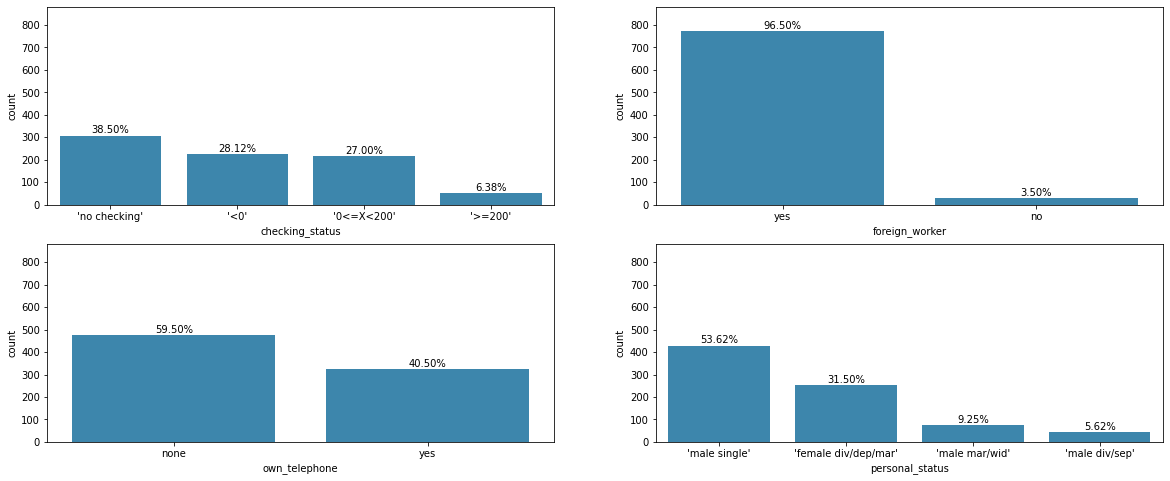

In [46]:
plt.figure(figsize=(20,8))
plt.subplot(221),grafico_com_porcetagem(train[['checking_status']],'checking_status')
plt.subplot(222),grafico_com_porcetagem(train[['foreign_worker']],'foreign_worker')
plt.subplot(223),grafico_com_porcetagem(train[['own_telephone']],'own_telephone')
plt.subplot(224),grafico_com_porcetagem(train[['personal_status']],'personal_status')
plt.show()

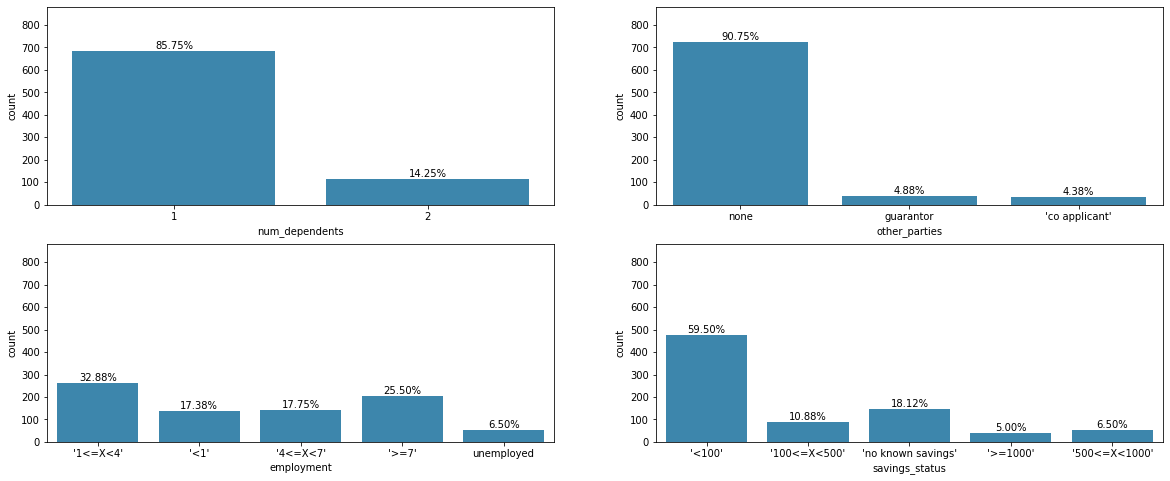

In [47]:
plt.figure(figsize=(20,8))
plt.subplot(221),grafico_com_porcetagem(train[['num_dependents']],'num_dependents')
plt.subplot(222),grafico_com_porcetagem(train[['other_parties']],'other_parties')
plt.subplot(223),grafico_com_porcetagem(train[['employment']],'employment')
plt.subplot(224),grafico_com_porcetagem(train[['savings_status']],'savings_status')
plt.show()

Analisando a class de crédito

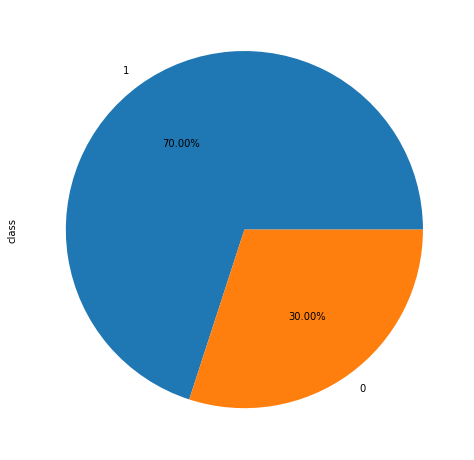

In [48]:
plt.figure(figsize=(8,12))
train['class'].value_counts().plot(kind='pie',autopct='%.2f%%');

Podemos observar que o dataset train tem cerca de 70% de crédito com risco **bom**.

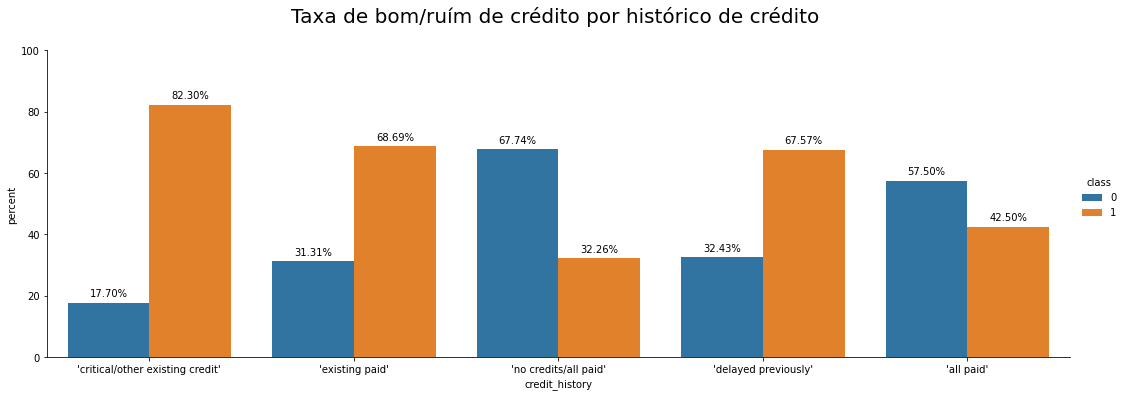

In [49]:
df1 = train.groupby('credit_history')['class'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index().sort_values(by=['percent'], ascending = True)

g = sns.catplot(x='credit_history',y='percent',hue='class',kind='bar',data=df1, height=5,aspect = 3,palette="tab10")
grafico_com_porcetagem_1(g)
plt.title('Taxa de bom/ruím de crédito por histórico de crédito \n', fontsize=20)
plt.show()

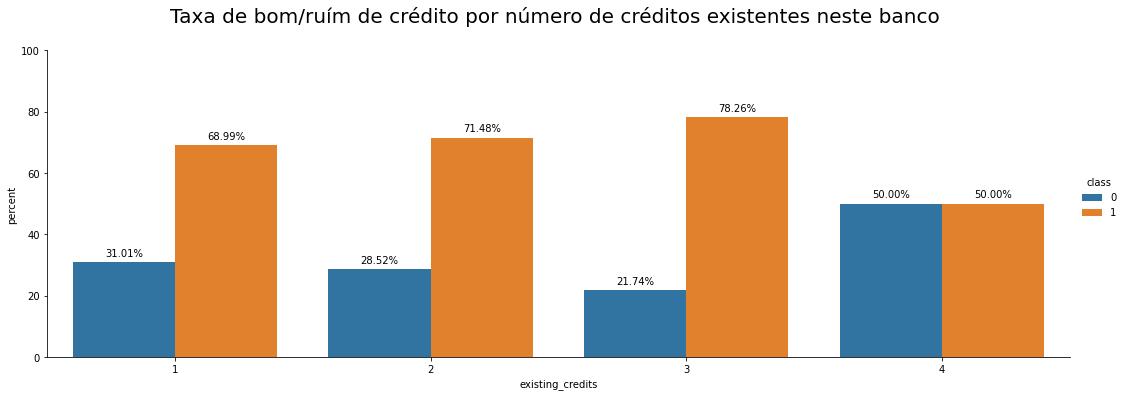

In [50]:
df1 = train.groupby('existing_credits')['class'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index().sort_values(by=['percent'], ascending = True)

g = sns.catplot(x='existing_credits',y='percent',hue='class',kind='bar',data=df1, height=5,aspect = 3,palette="tab10")
grafico_com_porcetagem_1(g)
plt.title('Taxa de bom/ruím de crédito por número de créditos existentes neste banco \n', fontsize=20)
plt.show()

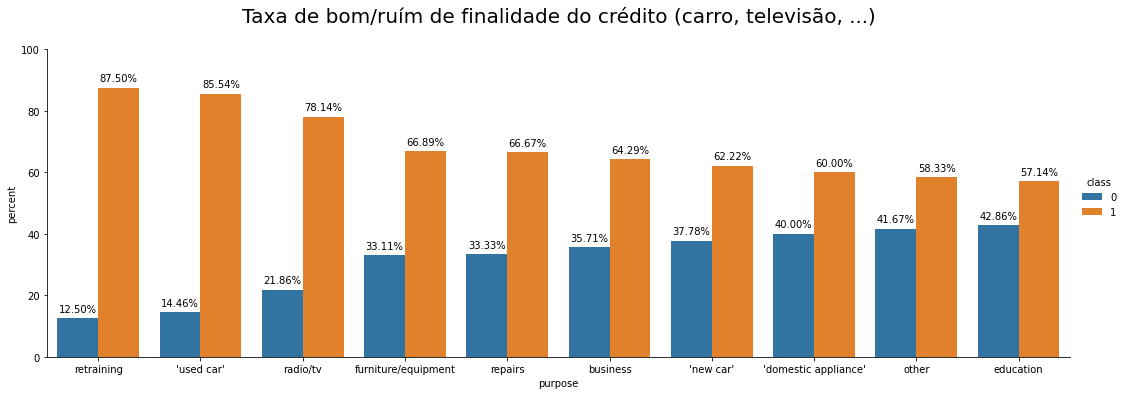

In [51]:
df1 = train.groupby('purpose')['class'].value_counts(normalize=True)*100
df1 = df1.rename('percent').reset_index().sort_values(by=['percent'], ascending = True)

g = sns.catplot(x='purpose',y='percent',hue='class',kind='bar',data=df1, height=5,aspect = 3)
grafico_com_porcetagem_1(g)
plt.title('Taxa de bom/ruím de finalidade do crédito (carro, televisão, ...)\n', fontsize=20)
plt.show()

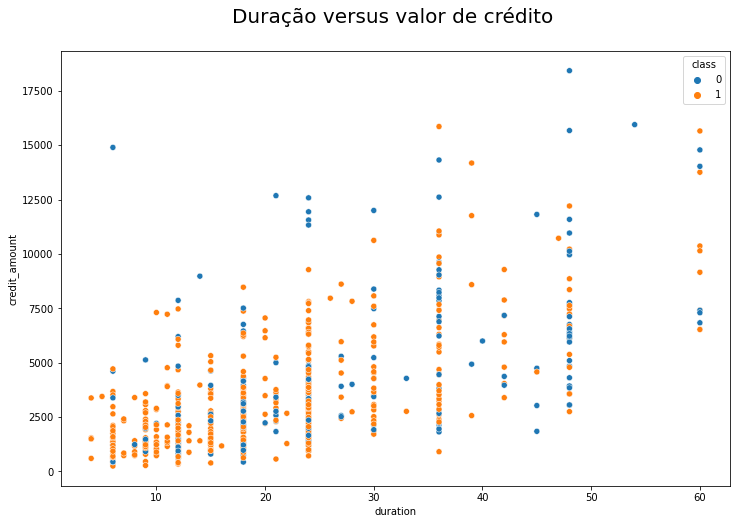

In [52]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='duration',y='credit_amount',hue='class',data=train,palette="tab10")
plt.title('Duração versus valor de crédito \n', fontsize=20)
plt.show()

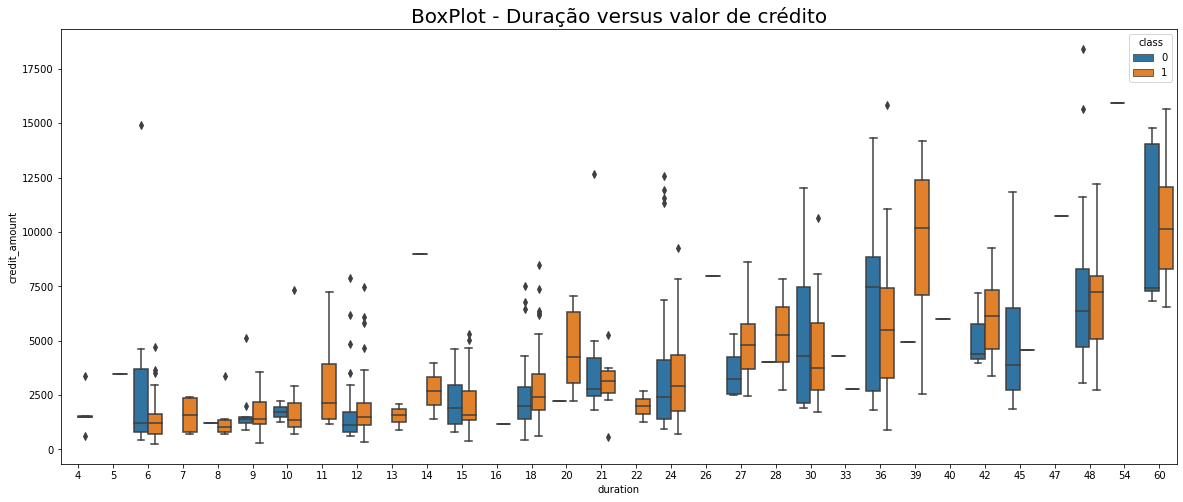

In [53]:
plt.figure(figsize=(20,8))
sns.boxplot(x='duration',y='credit_amount',hue='class',data=train,palette="tab10")
plt.title('BoxPlot - Duração versus valor de crédito',fontsize=20);
plt.show()

### Dividir dados

* Separando a variável resposta das variáveis preditoras

In [6]:
X = train[test.columns]
y= train["class"]
X_test = test

* Listando os índices das variáveis categóricas

In [7]:
cat_cols=X.select_dtypes("object").columns.tolist()
features=X.columns.tolist()
cat_indices = [features.index(col) for col in cat_cols]
cat_indices

[0, 2, 3, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

* Concatenando o dataset X com o dataset X_test

In [8]:
All_data = pd.concat([X, X_test], axis=0)

* Criando variáveis fictícias para as variáveis categóricas

In [9]:
all_data = pd.get_dummies(All_data, columns=cat_cols)

In [10]:
X2 = all_data[:len(X)]
X_test2 = all_data[len(X):]

In [11]:
X2.shape, X_test2.shape

((800, 61), (200, 61))

* Dividindo o dataset de treinamento e validação

In [12]:
Xtrain, Xval, ytrain, yval = train_test_split(X2, y, random_state=2021, train_size=0.8, stratify=y)

In [13]:
print(Xtrain.shape, Xval.shape, ytrain.shape, yval.shape, X_test2.shape)

(640, 61) (160, 61) (640,) (160,) (200, 61)


In [14]:
for i in all_data.columns:
  if i.split('_')[-1] in ('duration','age','amount','commitment','since', 'credits','dependents'):
    pass
  else:
    print(i.split('_')[-1])

'0<=X<200'
'<0'
'>=200'
'no checking'
'all paid'
'critical/other existing credit'
'delayed previously'
'existing paid'
'no credits/all paid'
'domestic appliance'
'new car'
'used car'
business
education
furniture/equipment
other
radio/tv
repairs
retraining
'100<=X<500'
'500<=X<1000'
'<100'
'>=1000'
'no known savings'
'1<=X<4'
'4<=X<7'
'<1'
'>=7'
unemployed
'female div/dep/mar'
'male div/sep'
'male mar/wid'
'male single'
'co applicant'
guarantor
none
'life insurance'
'no known property'
'real estate'
car
bank
none
stores
'for free'
own
rent
'high qualif/self emp/mgmt'
'unemp/unskilled non res'
'unskilled resident'
skilled
none
yes
no
yes


### Modelagem

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=50,
    mode='min',
    restore_best_weights=True)

callback = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=45, verbose=1),
            tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0.001,
    patience=50,
    verbose=2,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)]

In [16]:
# class_wt = compute_class_weight("balanced", np.unique(y), y)
# class_weights = {0:class_wt[0], 1:class_wt[1]}

In [17]:
# define the keras model
model = keras.Sequential()
model.add(keras.layers.Dense(64, input_dim=Xtrain.shape[1], activation='relu'))
model.add(keras.layers.Dense(120, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))  
model.add(keras.layers.Dense(1))#, activation='sigmoid')) 
model.add(keras.layers.Activation('sigmoid'))## activation='sigmoid' for binary class

# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tfa.metrics.F1Score(num_classes=1, threshold=0.55)], #
             )

# fit the keras model on the dataset
performance = model.fit(Xtrain, ytrain, epochs=5000, batch_size=32, validation_data=(Xval, yval), shuffle=False,
#                         class_weight=class_weights, 
#                         callbacks =[callback] 
    callbacks=[early_stopping],
                       )

Epoch 1/5000
20/20 [==============================] - 2s 18ms/step - loss: 23.2940 - f1_score: 0.6674 - val_loss: 6.1375 - val_f1_score: 0.8235
Epoch 2/5000
20/20 [==============================] - 0s 4ms/step - loss: 6.9552 - f1_score: 0.6508 - val_loss: 8.4797 - val_f1_score: 0.8235
Epoch 3/5000
20/20 [==============================] - 0s 4ms/step - loss: 6.6769 - f1_score: 0.6839 - val_loss: 0.6445 - val_f1_score: 0.6564
Epoch 4/5000
20/20 [==============================] - 0s 4ms/step - loss: 1.2545 - f1_score: 0.7169 - val_loss: 0.6197 - val_f1_score: 0.7081
Epoch 5/5000
20/20 [==============================] - 0s 4ms/step - loss: 4.0670 - f1_score: 0.7051 - val_loss: 7.0307 - val_f1_score: 0.0684
Epoch 6/5000
20/20 [==============================] - 0s 3ms/step - loss: 4.4192 - f1_score: 0.6217 - val_loss: 4.2866 - val_f1_score: 0.1760
Epoch 7/5000
20/20 [==============================] - 0s 4ms/step - loss: 5.0687 - f1_score: 0.6836 - val_loss: 3.9853 - val_f1_score: 0.8235
Epoc

### Avaliação de desempenho do modelo

In [18]:
performance.history['val_f1_score'].index(max(performance.history['val_f1_score'])), max(performance.history['val_f1_score'])

(123, array([0.8484848], dtype=float32))

In [19]:
performance.history['f1_score'].index(max(performance.history['f1_score'])), max(performance.history['f1_score'])

(225, array([0.8333333], dtype=float32))

In [20]:
[model.predict(Xval).round(0).shape,yval.shape]

[(160, 1), (160,)]

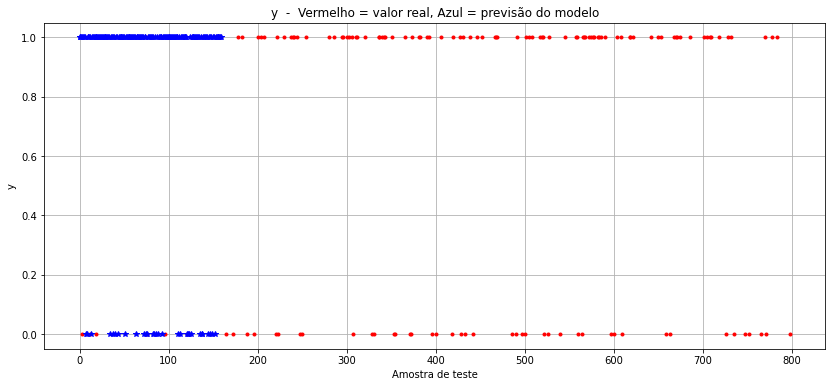

In [21]:
import matplotlib.pyplot as plt 
plt.subplots(figsize=(14,6))
plt.plot(yval,'r.')
plt.plot(model.predict(Xval).round(0).astype(int),'b*')
plt.xlabel('Amostra de teste')
plt.ylabel('y')
plt.title('y  -  Vermelho = valor real, Azul = previsão do modelo')
plt.grid(True)
plt.show()

### Previsão e apresentação

In [22]:
y_pred_test = model.predict(X_test2)

In [23]:
pd.DataFrame(y_pred_test)[0].apply(lambda x: int(round(x, 0))).value_counts()

1    160
0     40
Name: 0, dtype: int64

In [24]:
res = pd.DataFrame(y_pred_test) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
res.prediction = res.prediction.apply(lambda x: int(round(x, 0)))

* o arquivo csv será salvo localmente no mesmo local onde este bloco de notas está localizado.

In [25]:
res.to_csv("/content/prediction_results.csv", index = False)

In [26]:
res

,prediction
0,1
1,1
2,1
3,1
4,0
...,...
195,1
196,0
197,1
198,1


## Front-end: Criando um aplicativo da Web


* Instalando algumas bibliotecas que possibilitam o uso da biblioteca Dash no ambiente Jupyter notebook - Google Colab.

In [ ]:
!pip install dash
!pip install google-auth
!pip install pandas-gbq
!pip install jupyter_dash
!pip install dash-bootstrap-components

* Carregando bibliotecas

In [28]:
import dash
from jupyter_dash import JupyterDash 
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input, State
from datetime import date

import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from google.oauth2 import service_account  # pip install google-auth
import pandas_gbq  # pip install pandas-gbq

#### Criar aplicativo Dash

* As colunas preditoras 

In [29]:
prediction_col1 =  dbc.Col([ 
                html.Br(),
                dbc.Row([html.H3(children='Predição do Risco de Crédito')]),
                dbc.Row([
                    dbc.Col(html.Label(children='Status da conta corrente existente:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='checking_status',
                        options=[
                            {'label': 'sem conta corrente', 'value': 'sem conta corrente'},
                            {'label': 'menor que 0', 'value': '<0'},
                            {'label': 'maior ou igual a 0 e menor que 200', 'value': '0<=X<200'},
                            {'label': 'maior que 200', 'value': '>=200'}, 
                        ],
                        value='0<=X<200',
                        style = {"width": "50%", 'padding': '5px 0px 5px 10px', 'display': 'inline-block'}
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Duração em meses:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='duration', type='text', value = '4', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]), 
                dbc.Row([
                    dbc.Col(html.Label(children='Histórico de crédito:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='credit_history',
                        options=[
                            {'label': 'nenhum crédito / tudo pago', 'value': 'no credits/all paid'},
                            {'label': 'créditos recebidos', 'value': 'existing paid'},
                            {'label': 'pagos devidamente', 'value': 'all paid'},        
                            {'label': 'atrasos anteriormente', 'value': 'delayed previously'},
                            {'label': 'crédito crítico / outro existente', 'value': 'critical/other existing credit'},                 
                        ],
                        style = {"width": "30%", 'padding': '5px 0px 5px 10px' , 'display': 'inline-block'},
                        value='critical/other existing credit'
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Propósito:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dcc.Dropdown(
                        id='purpose',
                        options=[
                            {'label': 'rádio / tv', 'value': 'radio/tv'},
                            {'label': 'reparos', 'value': 'repairs'},
                            {'label': 'educação', 'value': 'education'},
                            {'label': 'móveis / equipamentos', 'value': 'furniture/equipment'},
                            {'label': 'negócio', 'value': 'business'},   
                            {'label': 'carro usado', 'value': 'used car'},         
                            {'label': 'carro novo', 'value': 'new car'},
                            {'label': 'retreinamento', 'value': 'retraining'},
                            {'label': 'eletrodoméstico', 'value': 'domestic appliance'},
                            {'label': 'outro', 'value': 'other'},                 
                        ],
                        style = {"width": "30%", 'padding': '5px 0px 5px 10px', 'display': 'inline-block' },
                        value='radio/tv'
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Quantidade de crédito:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='credit_amount', type='text', value = '1000', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),  
                dbc.Row([
                    dbc.Col(html.Label(children='Estado de poupança:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='savings_status',
                        options=[
                            {'label': 'nenhuma economia conhecida', 'value': 'no known savings'},
                            {'label': 'menor que 100', 'value': '<100'},
                            {'label': 'maior ou igual a 100 e menor que 500', 'value': '100<=X<500'},
                            {'label': 'maior ou igual a 500 e menor que 1000', 'value': '500<=X<1000'},
                            {'label': 'maior ou igual a 1000', 'value': '>=1000'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'no known savings',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]), 
                dbc.Row([
                    dbc.Col(html.Label(children='Emprego atual, em número de anos:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='employment',
                        options=[
                            {'label': 'desempregado (a)', 'value': 'unemployed'},
                            {'label': 'menor que 1', 'value': '<1'},
                            {'label': 'maior ou igual a 1 e menor que 4', 'value': '1<=X<4'},
                            {'label': 'maior ou igual a 4 e menor que 7', 'value': '4<=X<7'},
                            {'label': 'maior ou igual a 7', 'value': '>=7'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'unemployed',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                  dbc.Row([
                    dbc.Col(html.Label(children='Compromisso de parcelamento:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='installment_commitment',
                        options=[
                            {'label': '1', 'value': 1},
                            {'label': '2', 'value': 2},
                            {'label': '3', 'value': 3},
                            {'label': '4', 'value': 4}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 3,
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Status pessoal (casado, solteiro, ...) e sexo:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='personal_status',
                        options=[
                            {'label': 'homem solteiro', 'value': 'male single'},
                            {'label': 'mulher casada/separada/divorciada', 'value': 'female div/dep/mar'},
                            {'label': 'homem casado', 'value': 'male mar/wid'},
                            {'label': 'homem separado/divorciado', 'value': 'male div/sep'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'male single',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Outros devedores / fiadores:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='other_parties',
                        options=[
                            {'label': 'nenhum', 'value': 'none'},
                            {'label': 'fiador', 'value': 'guarantor'},
                            {'label': 'co-requerente', 'value': 'co applicant'},
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'guarantor',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Residência atual desde X anos:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='residence_since', type='text', value = '1', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Propriedade (por exemplo, imóveis):'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='property_magnitude',
                        options=[
                            {'label': 'carro', 'value': 'car'},
                            {'label': 'imobiliária', 'value': 'real estate'},
                            {'label': 'seguro de vida', 'value': 'life insurance'},
                            {'label': 'nenhuma propriedade conhecida', 'value': 'no known property'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'car',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Idade em anos:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='age', type='text', value = '18', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]), 
                 dbc.Row([
                    dbc.Col(html.Label(children='Outros planos de parcelamento (bancos, lojas):'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='other_payment_plans',
                        options=[
                            {'label': 'nenhum', 'value': 'none'},
                            {'label': 'banco', 'value': 'bank'},
                            {'label': 'lojas', 'value': 'stores'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'bank',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Habitação:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='housing',
                        options=[
                            {'label': 'próprio', 'value': 'own'},
                            {'label': 'aluguel', 'value': 'rent'},
                            {'label': 'grátis', 'value': 'for free'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'own',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]), 
                dbc.Row([
                    dbc.Col(html.Label(children='Número de créditos existentes neste banco:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='existing_credits', type='text', value = '0', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Trabalho:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='job',
                        options=[
                            {'label': 'qualificado', 'value': 'skilled'},
                            {'label': 'alto qualificado', 'value': 'high qualif/self emp/mgmt'},
                            {'label': 'residente não qualificado', 'value': 'unskilled resident'},
                            {'label': 'desocupado / não qualificado', 'value': 'unemp/unskilled non res'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'skilled',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Número de dependentes:'), width={"order": "first"}, style = {'padding': '15px 0px 0px 0px'}),
                    dbc.Col(dbc.Input(id='num_dependents', type='text', value = '0', style = {'padding': '5px 0px 5px 10px', 'width': '200px'}))
                ]),                       
                html.Br(),
                dbc.Row([
                    dbc.Col(html.Label(children='Telefone:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='own_telephone',
                        options=[
                            {'label': 'sim', 'value': 'yes'},
                            {'label': 'não', 'value': 'none'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'yes',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([
                    dbc.Col(html.Label(children='Trabalhador estrangeiro:'), width={"order": "first"}, style = {'padding': '5px 0px 5px 0px'}),
                    dbc.RadioItems(
                        id='foreign_worker',
                        options=[
                            {'label': 'sim', 'value': 'yes'},
                            {'label': 'não', 'value': 'no'}
                            ],
                        style = {"width": "60%", 'padding': '5px 0px 10px 10px', 'display': 'inline-block' },
                        value = 'yes',
                        labelStyle={'display': 'inline-block'},
                        inline=True # arrange list horizontally
                    )
                ]),
                dbc.Row([dbc.Button('Submit', id='submit-val', n_clicks=0, color="primary")]),
                html.Br(),
                dbc.Row([html.Div(id='container-button-basic')])
            ], style = {'padding': '0px 0px 0px 150px'})


 * Preparando o layout

In [55]:
external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = JupyterDash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div([
    html.H1(children='Risco de Crédito - Dashboard'),
    html.Div(children='''Risco de crédito  é calculado com base nos dados fornecido pelo  desafio Data Sprint 50 - Risco de Crédito da plataforma de competição de ciência de dados Dphi.'''),
    html.Div(children='Desenvolvedor: Rodrigo Tito'),
    html.Br(),

    dcc.Tabs(style = {'width': '100%'}, children=[
        # this is the  firt tab
        dcc.Tab(label='Análise do dataset', children = [
            dbc.Row([
                dbc.Col(
            html.Div([
                html.Label([
                 "X - Feature",
                 dcc.Dropdown(
                  id='x-dropdown', clearable=False,
                  value=df.columns[0], 
                  options=[ 
                   {'label': c, 'value': c} for c in df.columns 
                   ])
                 ]),
                 html.Label([
                  "Y - Feature",
                  dcc.Dropdown(
                   id='y-dropdown', clearable=False,
                    value=df.columns[0], options=[ {'label': c, 'value': c} for c in df.columns
                    ])
                  ]),
                  html.Label([ 
                  "Color - Feature",
                  dcc.Dropdown(
                  id='color-dropdown', clearable=False,
                  value=df.columns[0], options=[ {'label': c, 'value': c} for c in df.columns                        
                  ])           
                ])
            ])
            )
                ]),
                dbc.Row([
                    dbc.Col(html.Div(dcc.Graph(id='bar-graph'), style = {'width': '100%'}))
                ]) 
        ]), # the end of the firt tab

        # this is the second tab
        dcc.Tab(label='Predição do Risco de Crédito', children = [
            dbc.Row([prediction_col1])
        ]) # the end of the second tab

    ]) # end of all tabs

], style = {'padding': '20px'}) # the end of app.layout

* criando retorno do dash

In [56]:
#############################
# criar retorno para gráfico de barras
@app.callback(
    Output('bar-graph', 'figure'),
    Input("x-dropdown","value"),
     Input("y-dropdown","value"),
     Input("color-dropdown","value")
)
def update_bar_graph (feature_x,feature_y,color):
    fig = px.bar(df, x = feature_x, y = feature_y, color = color, title=f' {feature_x} versus {feature_y}',
                 height=500
    )
    fig.update_layout(
        title  = {'x':0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': {'size': 20}},
        hovermode = 'x unified',
        hoverlabel = {'font_size': 16, 'font_family': "Rockwell", 'namelength': 20,'font': {'size': 20}}
    )
    fig.update_traces(hovertemplate=None)
    
    return fig
##############################
# criar retorno para predição
@app.callback(
    Output('container-button-basic', 'children'),
    # As entradas irão acionar seu callback;
    [Input('submit-val', 'n_clicks'),
    State('checking_status', 'value'),
    State('duration', 'value'),
    State('credit_history', 'value'), 
    State('purpose', 'value'),
    State('credit_amount', 'value'),
    State('savings_status', 'value'),
    State('employment', 'value'),
    State('installment_commitment', 'value'),
    State('personal_status', 'value'),
    State('other_parties', 'value'),
    State('residence_since', 'value'),
    State('property_magnitude', 'value'),
    State('age', 'value'),
    State('other_payment_plans', 'value'),
    State('housing', 'value'),
    State('existing_credits', 'value'),
    State('job', 'value'),
    State('num_dependents', 'value'),
    State('own_telephone', 'value'),
    State('foreign_worker', 'value')]
    ) 
   
def update_output(n_clicks, checking_status,	duration,	credit_history,	purpose,	credit_amount,
                  savings_status,	employment,	installment_commitment,	personal_status,	other_parties,
                  residence_since,	property_magnitude,	age,	other_payment_plans,	housing,	existing_credits,
                  job,	num_dependents,	own_telephone,	foreign_worker):
    
    result = []
    for col in all_data.columns:
      if col.split('_')[-1] in ('duration','amount','commitment','since','age', 'credits','dependents'):
        result.append(int(locals()[col]))
      else:
        if col.split('_')[-1] == (locals()['_'.join(col.split('_')[:-1])]):
          result.append(1)
        else:
          result.append(0)
    dict_from_list = dict(zip(all_data.columns, result))
    query = pd.DataFrame(dict_from_list,index = [0],columns = all_data.columns)      
    
    prediction = int(model.predict(query)[0].round(0))
    output = int(prediction)
    if output == 1 :
      if  model.predict(query)[0]>0.5 and model.predict(query)[0] < 0.8:
        return html.H1(children='RISCO DE CRÉDITO DE '+ f'{(100-(model.predict(query)[0][0])*100).round(2)}'+'%' + ": REGULAR!")
      else:
        return html.H1(children='RISCO DE CRÉDITO DE '+ f'{(100-(model.predict(query)[0][0])*100).round(2)}' +'%'+ ": BOM!")
    else:
       return  html.H1(children='RISCO DE CRÉDITO DE '+ f'{(100-(model.predict(query)[0][0])*100).round(2)}' +'%' + ": RUIM!") 

if __name__ == '__main__':
    app.run_server(debug=True)

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
!pip install pyngrok

In [ ]:
! ngrok authtoken xxxxxxxxxx 

In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect('8050')
public_url